In [62]:
import math
import csv
from io import BytesIO

import tensorflow as tf
import numpy as np
import PIL.Image
import IPython.display
import matplotlib.pyplot as plt

from utils import load_training_set, one_hot, norm_imgs, split_train_test
from utils import get_random_minibatches

%matplotlib inline

In [125]:
def show_digit(a, fmt='png'):
    """To do: optionally show label here."""
    a = a.reshape((28, 28))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
def plot_costs(costs):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 5)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
def predict(x, weights, biases, forward_prop):
    weights = {key: tf.convert_to_tensor(var) for key, var in weights.items()}
    biases = {key: tf.convert_to_tensor(var) for key, var in biases.items()}
    
    x_ = tf.placeholder(tf.float32, [None, x.shape[1]])
    
    out_layer = forward_prop(x_, weights, biases)
    p = tf.argmax(out_layer, 1)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x_: x})
    sess.close()
    return prediction

def load_test_set(filepath):
    fh = open('./data/test.csv')
    test_reader = csv.reader(fh)
    
    # Skip header line
    _ = next(test_reader)

    test_imgs = [line for line in test_reader]

    return np.uint8(test_imgs)

def save_predictions(predictions, filepath='output.csv'):
    """Save predictions to an output path."""
    output = open(filepath, 'w')
    output.write(u'ImageId,Label\n')
    [output.write(u'{0},{1}\n'.format(count + 1, pred)) 
        for count, pred in enumerate(predictions)]
    output.close()
    
   
class Epochs(object):
    
    def __init__(
        self, sess, optimizer, cost, accuracy, num_epochs=100,
        mini_batch_size=64, print_every=10
    ):
        self.sess = sess
        self.optimizer = optimizer
        self.cost = cost
        self.accuracy = accuracy
        self.num_epochs = num_epochs
        self.mini_batch_size = mini_batch_size
        self.print_every = print_every
        
    def run(self, train_x, train_y):
        num_mini_batches = train_x.shape[0] / self.mini_batch_size
        
        costs = []
        
        for epoch in range(1, self.num_epochs + 1):
            epoch_cost = 0.
            for mini_x, mini_y in get_random_minibatches(train_x, train_y, self.mini_batch_size):
                _, batch_cost = sess.run([optimizer, cost], feed_dict={x: mini_x, y: mini_y})
                epoch_cost += batch_cost / num_mini_batches

            if epoch % print_every == 0:
                print("Cost at {0} epochs = {1}.".format(epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)

        return costs

## Data Preparation

Data comes in CSV format, where the first column is the label and the others represent a pixel intensity value between 0 and 255, in cells 0 to 783 (allowing for 784 cells or 28 x 28).

Going to load the labels and pixel values into a list, then create a numpy array for them both.

In [3]:
imgs, labels = load_training_set('./data/train.csv')

In [4]:
show_digit(imgs[305])

Next, converting the labels into a one hot matrix and normalising the pixel values by dividing by the max.

In [5]:
labels_one_hot = one_hot(labels, 10)
imgs_norm = norm_imgs(imgs)

In [6]:
assert labels_one_hot.shape == (len(labels), 10)

Then split into train/test.

In [7]:
train_x, train_y, dev_x, dev_y = split_train_test(imgs_norm, labels_one_hot, ratio=0.2)

## Simple Neural Net

Going to start with a baseline 3-layer NN and see what sort of performance I get.

In [45]:
learning_rate = 0.0001
num_epochs = 100
print_every = 10
mini_batch_size = 64
sample_size = 2000

In [83]:
tf.reset_default_graph()

def dense_model(x, weights, biases):
    """Simple 3 layer neural net."""
    z1 = tf.matmul(x, weights['wd1']) + biases['bd1']
    fc1 = tf.nn.relu(z1)
    z2 = tf.matmul(fc1, weights['wd2']) + biases['bd2']
    fc2 = tf.nn.relu(z2)
    out = tf.matmul(fc2, weights['out']) + biases['bout']
    return out

xavier = tf.contrib.layers.xavier_initializer(seed=1)
weights = {
    'wd1': tf.get_variable('wd1', shape=[784, 256], initializer=xavier),
    'wd2': tf.get_variable('wd2', shape=[256, 256], initializer=xavier),
    'out': tf.get_variable('out', shape=[256, 10], initializer=xavier)
}

zeros_initer = tf.zeros_initializer()
biases = {
    'bd1': tf.get_variable('bd1', shape=[1, 256], initializer=zeros_initer),
    'bd2': tf.get_variable('bd2', shape=[1, 256], initializer=zeros_initer),
    'bout': tf.get_variable('bout', shape=[1, 10], initializer=zeros_initer)
}

# Graph input
x = tf.placeholder(tf.float32, shape=(None, 784), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')

# Forward prop
pred = dense_model(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

Cost at 10 epochs = 0.08304346367539395.
Cost at 20 epochs = 0.02703981552029117.
Cost at 30 epochs = 0.006789704098732073.
Cost at 40 epochs = 0.0012074729951910693.
Cost at 50 epochs = 0.00016943211571829336.
Cost at 60 epochs = 1.9304285045493675e-05.
Cost at 70 epochs = 1.9428063540347235e-06.
Cost at 80 epochs = 1.8789602894729378e-07.
Cost at 90 epochs = 2.3866685042040978e-08.
Cost at 100 epochs = 6.2336516898618176e-09.


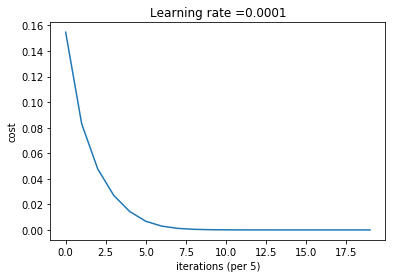

Train Accuracy: 0.999999
Test Accuracy: 0.974524


In [87]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    costs = Epochs(sess, optimizer, cost, accuracy).run(train_x, train_y)

    plot_costs(costs)

    # Save params
    saved_weights = sess.run(weights)
    saved_biases = sess.run(biases)
    
    # Save checkpoint
    saver.save(sess, './3_layer_nn.ckpt')

    print ("Train Accuracy:", accuracy.eval({x: train_x, y: train_y}))
    print ("Test Accuracy:", accuracy.eval({x: dev_x, y: dev_y}))

Can't really beat that for train accuracy! Let's see how the model does on the test data.

In [88]:
test_imgs = load_test_set('./data/train.csv')
test_imgs_norm = test_imgs / 255.

In [94]:
predictions = predict(test_imgs_norm, saved_weights, saved_biases, dense_model)

In [95]:
show_digit(test_imgs[0]), predictions[0]

(None, 2)

In [96]:
save_predictions(predictions)

Achieved 0.97285, which puts me at 919th. Let's see what happens when I add another 2 layers.

## Slightly Larger Neural Net

In [100]:
tf.reset_default_graph()

def dense_model_5l(x, weights, biases):
    """Simple 3 layer neural net."""
    z1 = tf.matmul(x, weights['wd1']) + biases['bd1']
    fc1 = tf.nn.relu(z1)
    z2 = tf.matmul(fc1, weights['wd2']) + biases['bd2']
    fc2 = tf.nn.relu(z2)
    z3 = tf.matmul(fc2, weights['wd3']) + biases['bd3']
    fc3 = tf.nn.relu(z3)
    z4 = tf.matmul(fc3, weights['wd4']) + biases['bd4']
    fc4 = tf.nn.relu(z4)
    out = tf.matmul(fc4, weights['out']) + biases['bout']
    return out

weights = {
    'wd1': tf.get_variable('wd1', shape=[784, 256], initializer=xavier),
    'wd2': tf.get_variable('wd2', shape=[256, 256], initializer=xavier),
    'wd3': tf.get_variable('wd3', shape=[256, 256], initializer=xavier),
    'wd4': tf.get_variable('wd4', shape=[256, 256], initializer=xavier),
    'out': tf.get_variable('out', shape=[256, 10], initializer=xavier)
}

zeros_initer = tf.zeros_initializer()
biases = {
    'bd1': tf.get_variable('bd1', shape=[1, 256], initializer=zeros_initer),
    'bd2': tf.get_variable('bd2', shape=[1, 256], initializer=zeros_initer),
    'bd3': tf.get_variable('bd3', shape=[1, 256], initializer=zeros_initer),
    'bd4': tf.get_variable('bd4', shape=[1, 256], initializer=zeros_initer),
    'bout': tf.get_variable('bout', shape=[1, 10], initializer=zeros_initer)
}

# Graph input
x = tf.placeholder(tf.float32, shape=(None, 784), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')

# Forward prop
pred = dense_model_5l(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

Cost at 10 epochs = 0.038024624761726154.
Cost at 20 epochs = 0.007882580723006466.
Cost at 30 epochs = 0.0025960843369756733.
Cost at 40 epochs = 8.784673342306963e-05.
Cost at 50 epochs = 8.656716566425033e-06.
Cost at 60 epochs = 5.958022685339942e-07.
Cost at 70 epochs = 3.57414783953252e-08.
Cost at 80 epochs = 2.9944235785130857e-09.
Cost at 90 epochs = 0.005330799816619947.
Cost at 100 epochs = 3.07011244511183e-05.


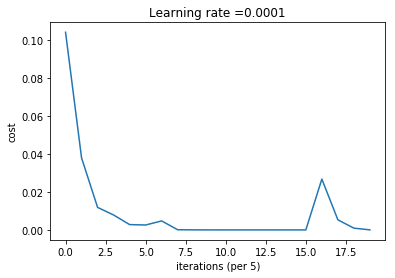

Train Accuracy: 0.999999
Test Accuracy: 0.975357


In [101]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    costs = Epochs(sess, optimizer, cost, accuracy).run(train_x, train_y)

    plot_costs(costs)

    # Save params
    saved_weights = sess.run(weights)
    saved_biases = sess.run(biases)
    
    # Save checkpoint
    saver.save(sess, './5_layer_nn.ckpt')

    print ("Train Accuracy:", accuracy.eval({x: train_x, y: train_y}))
    print ("Test Accuracy:", accuracy.eval({x: dev_x, y: dev_y}))

Slightly better. Gets me a score of 0.97357, which gets me to 911 place - about 8 places better than before.

Looks like I'm overfitting, since the training accuracy is close to 100%, so let's think about:

  * Regularisation (L2 norm, dropout)
  * Maybe data augmentation?
  * Different architecture? CNN etc.

Let's start with regularisation. Regularisation is a technique for encouraging weights to be smaller by basically adding the weights to the cost function. The point of it is to ensure a single weight doesn't get too big, thus overfitting the training data, and therefore we hope it generalises better on the dev/test set. L2 regularisation is simply the sum of the squared weights. Something like:

$\sum\limits_{i=1}^{k} {w_i}^2$

You also provide a "lambda" component that represents how much regularisation you want. A very high lambda, will ensure regularisation has a huge impact. A lambda of 0, will ensure regularisation has no impact. Tensorflow provides a method for implementing L2 regularisation in the cost function in `tf.nn.l2_loss` and would be implemented as follows:

```
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
cost += 0.01 * tf.nn.l2_loss(weights)
```

Note: generally you don't need to regularise the bias term. I have gone back and refactored the `get_cost` method to add l2 reg.

## Neural Net with L2 Reg

In [104]:
# Cost with L2 penalty.
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
for key, val in weights.items():
    cost += 0.001 * tf.nn.l2_loss(val)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Cost at 10 epochs = 0.3689410477025169.
Cost at 20 epochs = 0.22481579613117963.
Cost at 30 epochs = 0.14487573879105708.
Cost at 40 epochs = 0.10991901735464742.
Cost at 50 epochs = 0.09348163339353749.
Cost at 60 epochs = 0.08667908610332578.
Cost at 70 epochs = 0.07979310047058827.
Cost at 80 epochs = 0.07807796430020106.
Cost at 90 epochs = 0.07642236336356113.
Cost at 100 epochs = 0.07902042764992945.


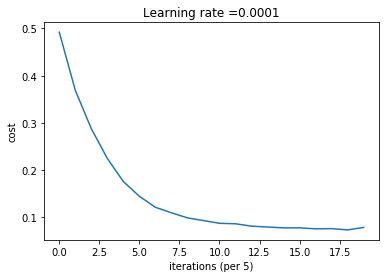

Train Accuracy: 0.99854
Test Accuracy: 0.972381


In [105]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    costs = Epochs(sess, optimizer, cost, accuracy).run(train_x, train_y)

    plot_costs(costs)

    # Save params
    saved_weights = sess.run(weights)
    saved_biases = sess.run(biases)
    
    # Save checkpoint
    saver.save(sess, './5_layer_nn_l2.ckpt')

    print ("Train Accuracy:", accuracy.eval({x: train_x, y: train_y}))
    print ("Test Accuracy:", accuracy.eval({x: dev_x, y: dev_y}))

It appears to take much longer to converge and training accuracy has decreased. Seems to have helped with overfitting a lil but hasn't helped with dev accuracy. Let's get drastic and introduce a conv layer with dropout.

## Small Convolution Neural Network

Conv layers are essentially a tool for performing automated feature engineering, discovering stand out patterns an dd the like in the image content. They can be implemented in Tensorflow using `tf.nn.conv2d`.

Going to see if I can improve upon the dev accuracy with a simple 2 conv and 3 FC network.

In [111]:
tf.reset_default_graph()

def conv_2d_block(x, weight, bias, strides=1):
    # Strides refers to the "stride of the sliding window for each dimension of input"
    x = tf.nn.conv2d(x, weight, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, bias)
    x = tf.nn.relu(x)
    return x


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


def conv_net(x, weights, biases, keep_prob=1):
    # Need to be reshaped from flattened format for some reason?
    # Tensorflow is 4d: (height, width, num channels, dataset size)
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    conv1 = conv_2d_block(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    
    conv2 = conv_2d_block(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    
    # Need to flatten out the output for the fully connected layers
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    # Apply Dropout in fully-connected layer
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['bout'])
    
    return out


weights = {
    'wc1': tf.get_variable('wc1', [5, 5, 1, 32], initializer=xavier),
    'wc2': tf.get_variable('wc2', [5, 5, 32, 64], initializer=xavier),
    'wd1': tf.get_variable('wd1', [7*7*64, 1024], initializer=xavier),
    'out': tf.get_variable('out', [1024, 10], initializer=xavier)
}

biases = {
    'bc1': tf.get_variable('bc1', [32], initializer=zeros_initer),
    'bc2': tf.get_variable('bc2', [64], initializer=zeros_initer),
    'bd1': tf.get_variable('bd1', [1024], initializer=zeros_initer),
    'bout': tf.get_variable('bout', [10], initializer=zeros_initer)
}

# Graph input
x = tf.placeholder(tf.float32, shape=(None, 784), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')

# Forward prop
pred = conv_net(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

Cost at 10 epochs = 0.017056850735430725.
Cost at 20 epochs = 0.006346759873551838.
Cost at 30 epochs = 0.0060927267088421435.
Cost at 40 epochs = 6.565905221851234e-05.
Cost at 50 epochs = 0.00015860413668425123.
Cost at 60 epochs = 8.268312847394508e-06.
Cost at 70 epochs = 8.101901206558104e-07.
Cost at 80 epochs = 8.699604760698285e-06.
Cost at 90 epochs = 9.510804320054348e-07.
Cost at 100 epochs = 9.441619282402061e-08.


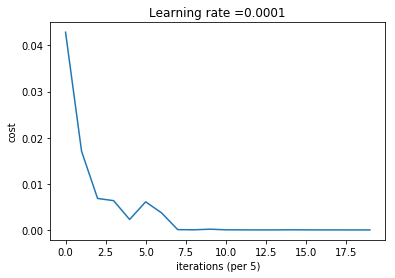

Train Accuracy: 0.999999
Test Accuracy: 0.98881


In [112]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    costs = Epochs(sess, optimizer, cost, accuracy).run(train_x, train_y)

    plot_costs(costs)

    # Save params
    saved_weights = sess.run(weights)
    saved_biases = sess.run(biases)
    
    # Save checkpoint
    saver.save(sess, './cnn.ckpt')

    print ("Train Accuracy:", accuracy.eval({x: train_x, y: train_y}))
    print ("Test Accuracy:", accuracy.eval({x: dev_x, y: dev_y}))

In [114]:
predictions = predict(test_imgs_norm, saved_weights, saved_biases, conv_net)

In [115]:
save_predictions(predictions, 'conv_predictions.csv')

Holy shit!

You advanced 546 places on the leaderboard!
Your submission scored 0.99128, which is an improvement of your previous score of 0.97357.

Next up, let's try pseudo-labelling. Where our model is "trained in a supervised fashion with labeled and unlabeled data simultaneously. For unlabeled data, Pseudo-Labels, just picking up the class which has the maximum predicted probability every weights update, are used as if they were true labels."

## Pseudo labelling

In [116]:
pseudo_test_labels = one_hot(predictions, 10)

In [118]:
print(test_imgs_norm.shape)
print(train_x.shape)
print(train_y.shape)
print(pseudo_test_labels.shape)

(28000, 784)
(33600, 784)
(33600, 10)
(28000, 10)


In [119]:
# Create a new x and y concatenating the train and test data.
pseudo_x = np.concatenate([train_x, test_imgs_norm])
pseudo_y = np.concatenate([train_y, pseudo_test_labels])

In [121]:
print(pseudo_x.shape)
print(pseudo_y.shape)

(61600, 784)
(61600, 10)


So we are almost doubling our training set. Let's see how we go!

Cost at 10 epochs = 0.007954768680713388.
Cost at 20 epochs = 0.002819270832757993.
Cost at 30 epochs = 0.0017868660449980118.
Cost at 40 epochs = 0.0016041284174197086.
Cost at 50 epochs = 2.4763114098218713e-05.
Cost at 60 epochs = 2.0077586010575573e-05.
Cost at 70 epochs = 0.0018829280603535282.
Cost at 80 epochs = 6.87268844323451e-07.
Cost at 90 epochs = 0.00013379176008166207.
Cost at 100 epochs = 4.5902159885259003e-07.


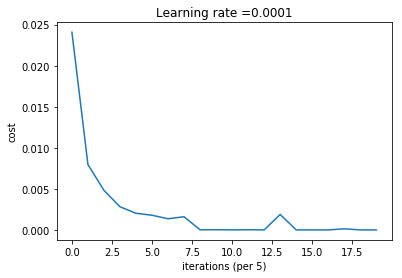

Test Accuracy: 0.990715


In [317]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    costs = Epochs(sess, optimizer, cost, accuracy).run(pseudo_x, pseudo_y)

    plot_costs(costs)

    # Save params
    saved_weights = sess.run(weights)
    saved_biases = sess.run(biases)
    
    # Save checkpoint
    saver.save(sess, './cnn_pseudo.ckpt')

    print ("Test Accuracy:", accuracy.eval({x: dev_x, y: dev_y}))

In [319]:
pseudo_predictions = predict(test_imgs_norm, saved_weights, saved_biases, conv_net)
save_predictions(pseudo_predictions, 'pseudo_label_conv_predictions.csv')

## Model Evaluation

Didn't help at all...let's look at some of the bad predictions from the dev set.

In [320]:
dev_predictions = predict(dev_x, saved_weights, saved_biases, conv_net)

In [321]:
bad_predictions = dev_predictions != np.argmax(dev_y, 1)

In [322]:
dev_imgs = dev_x * 255
dev_labels = np.argmax(dev_y, 1)

In [323]:
bad_imgs = dev_imgs[bad_predictions]
bad_labels = dev_predictions[bad_predictions]
actual_labels = dev_labels[bad_predictions]

In [325]:
for i in range(0, 10):
    print('Predicted {0}, actual {1}'.format(bad_labels[i], actual_labels[i]))
    show_digit(np.uint8(bad_imgs[i]))

Predicted 8, actual 5


Predicted 4, actual 1


Predicted 2, actual 3


Predicted 9, actual 4


Predicted 5, actual 8


Predicted 0, actual 9


Predicted 7, actual 2


Predicted 3, actual 7


Predicted 2, actual 1


Predicted 8, actual 9


Seems to be struggling with the poorly written labels. I'm thinking some light data augmentation may help a little bit?

Start with rotation range.

## Data augmentation

In [318]:
gen = tf.contrib.keras.preprocessing.image.ImageDataGenerator(rotation_range=0.1)
random = gen.random_transform(train_x.reshape(-1, 784, 1), seed=42)
show_digit(np.uint8(random[10] * 255))

Play with zoom range too.

In [291]:
gen = tf.contrib.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.03)
random = gen.random_transform(train_x.reshape(-1, 28, 28, 1), seed=42)
show_digit(np.uint8(random[10] * 255))

In [296]:
gen = tf.contrib.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.03, rotation_range=0.1)

Cost at 10 epochs = 0.018868892244589947.
Cost at 20 epochs = 0.0044688371736646346.
Cost at 30 epochs = 0.0012921704514270629.
Cost at 40 epochs = 0.000813735379515492.
Cost at 50 epochs = 0.004499603806870287.
Cost at 60 epochs = 9.888685709936013e-05.
Cost at 70 epochs = 0.00019204514981416705.
Cost at 80 epochs = 1.007818992651349e-05.
Cost at 90 epochs = 8.14517833379655e-06.
Cost at 100 epochs = 1.2189900996006288e-05.


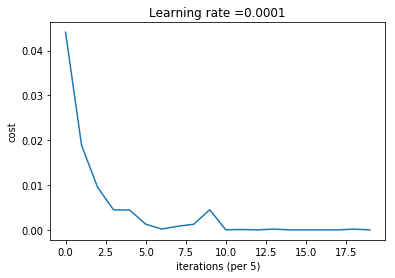

Test Accuracy: 0.989524


In [315]:
class EpochsFromBatches(Epochs):
    
    """To do: clean me up."""
    
    def run(self, train_x, train_y, gen):
        num_mini_batches = train_x.shape[0] / self.mini_batch_size
        
        costs = []
        
        for epoch in range(1, self.num_epochs + 1):
            epoch_cost = 0.
            
            batch_count = 0
            for mini_x, mini_y in gen.flow(train_x, train_y, batch_size=self.mini_batch_size):
                mini_x = mini_x.reshape((-1, 784))
                _, batch_cost = sess.run([optimizer, cost], feed_dict={x: mini_x, y: mini_y})
                epoch_cost += batch_cost / num_mini_batches
                batch_count += 1
                
                if batch_count > (num_mini_batches):
                    break

            if epoch % print_every == 0:
                print("Cost at {0} epochs = {1}.".format(epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)

        return costs
        
train_x_3d = train_x.reshape(-1, 28, 28, 1)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    costs = EpochsFromBatches(sess, optimizer, cost, accuracy).run(train_x_3d, train_y, gen)

    plot_costs(costs)

    # Save params
    saved_weights = sess.run(weights)
    saved_biases = sess.run(biases)
    
    # Save checkpoint
    saver.save(sess, './cnn_pseudo_aug.ckpt')

    print ("Test Accuracy:", accuracy.eval({x: dev_x, y: dev_y}))

In [316]:
aug_predictions = predict(test_imgs_norm, saved_weights, saved_biases, conv_net)
save_predictions(aug_predictions, 'aug_predictions.csv')

Didn't help at all :(

Let's try a bigger architecture.

## Larger CNN (5 conv and 3 FC)

To do.